# Open Backtrack files and plot moisture sources

In [80]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

import network_arch as network
import metrics
import plot as plot
import settings
import functions_misc as fnc


from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import pop_tools

import netCDF4 as nc
#import plots as plots
import matplotlib as mpl
import cmocean.cm as cmo


In [82]:
#ddir_X = '/Users/marcodia/Research/Data/Moisture_Tracking/MidwestMBA_Aug11/'
#ddir_X = '/Users/marcodia/Research/Data/Moisture_Tracking/SouthUSMBA_Aug30/'
#ddir_X = '/Users/marcodia/Research/Data/Moisture_Tracking/case_3_midwest_2013/'
ddir_X = '/Users/marcodia/Research/Data/Moisture_Tracking/case_1_missouri_2011/'

ddir_out = '/Users/marcodia/Research/Data/Moisture_Tracking/output/' 


In [83]:
# STRT_I = pd.to_datetime('01-02-2000')
# END_I   = pd.to_datetime('12-30-2022')  + dt.timedelta(days=1)
# time_range = xr.cftime_range(str(STRT_I)[:10], str(END_I)[:10])#,calendar = 'noleap') #[0:10] corresponds to full datestamp
# TIME_ALL = xr.DataArray(time_range + dt.timedelta(days=0), dims=['time'])  

# STRT_I = pd.to_datetime('01-02-2008')
# END_I   = pd.to_datetime('03-29-2021')  + dt.timedelta(days=1)
# time_range = xr.cftime_range(str(STRT_I)[:10], str(END_I)[:10])#,calendar = 'noleap') #[0:10] corresponds to full datestamp
# TIME_ALL = xr.DataArray(time_range + dt.timedelta(days=0), dims=['time'])    

STRT_I = pd.to_datetime('05-01-2011')
END_I   = pd.to_datetime('06-29-2011')  + dt.timedelta(days=1)
time_range = xr.cftime_range(str(STRT_I)[:10], str(END_I)[:10])#,calendar = 'noleap') #[0:10] corresponds to full datestamp
TIME_ALL = xr.DataArray(time_range + dt.timedelta(days=0), dims=['time'])    


# STRT_I = pd.to_datetime('05-27-2013')
# END_I   = pd.to_datetime('06-03-2013')  + dt.timedelta(days=1)
# time_range = xr.cftime_range(str(STRT_I)[:10], str(END_I)[:10])#,calendar = 'noleap') #[0:10] corresponds to full datestamp
# TIME_ALL = xr.DataArray(time_range + dt.timedelta(days=0), dims=['time'])    


STRT_2 = pd.to_datetime('05-01-2008')
END_2   = pd.to_datetime('08-31-2020')  + dt.timedelta(days=1)
time_range2 = xr.cftime_range(str(STRT_2)[:10], str(END_2)[:10])#,calendar = 'noleap') #[0:10] corresponds to full datestamp
time_range_2 = time_range2.where(fnc.is_mjja(time_range2.month)).dropna()
TIME_X = xr.DataArray(time_range_2 + dt.timedelta(days=0), dims=['time'])   


In [84]:
TIME_X

<xarray.DataArray (time: 1599)>
array([cftime.DatetimeGregorian(2008, 5, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2008, 5, 2, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2008, 5, 3, 0, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(2020, 8, 29, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2020, 8, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2020, 8, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 2008-05-01 00:00:00 ... 2020-08-31 00:00:00

In [85]:
#TIME_ALL

In [86]:
readin_data = xr.open_mfdataset(ddir_X+'backtrack*00.nc', combine = 'nested', concat_dim="time")
#readin_data = xr.open_mfdataset(ddir_X+'backtrack*_00.nc', combine = 'nested', concat_dim="time")

In [87]:
#readin_data.time

In [88]:
e_track = readin_data['e_track']
e_track.time
e_track['time'] = TIME_ALL


In [89]:
e_track.time
e_track_timeslice = e_track.where(e_track.time == TIME_X, drop=True)

#Sum e_track data 
e_track_sum = xr.DataArray(np.sum(e_track_timeslice,axis=0))
e_track_sum_X = e_track_sum.compute()
e_track_sum_X

<xarray.DataArray 'e_track' (latitude: 641, longitude: 1440)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.7368794e+03, 2.7333064e+03, 2.7327275e+03, ..., 2.6574675e+03,
        2.6798181e+03, 2.7049861e+03],
       [2.9342788e+03, 2.9387051e+03, 2.9431035e+03, ..., 2.8465454e+03,
        2.8704604e+03, 2.8975483e+03],
       ...,
       [7.0558199e-05, 4.2098087e-05, 3.9502534e-05, ..., 1.0515208e-04,
        9.8347205e-05, 7.5377255e-05],
       [2.8477862e-04, 3.2238508e-04, 2.7480148e-04, ..., 2.5883986e-04,
        2.4896237e-04, 2.3181585e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... -79.5 -79.75 -80.0

In [91]:
total_precip_water = np.sum(e_track_sum_X)
total_precip_water

<xarray.DataArray 'e_track' ()>
array(4.3745827e+11, dtype=float32)

In [95]:
box_lon1 = -104 #202.5
box_lon2 = -90   #220
box_lat1 = 36
box_lat2 = 43



In [96]:
# Caribbean/GoM
# min_lon = 262 #-98 
# min_lat = 30
# max_lon = 320 #-40 
# max_lat = 11

#Local Recycling for 2013 Case Study
# min_lon = 256 
# min_lat = 43
# max_lon = 270 
# max_lat = 36 

#Local Recycling for 2011 Case Study (just full Midwest region)
min_lon = 254  
min_lat = 49
max_lon = 270  
max_lat = 36 

origin_box = e_track_sum_X.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))

origin_box

<xarray.DataArray 'e_track' (latitude: 53, longitude: 65)>
array([[ 4281563. ,  4327282. ,  4271108. , ...,  2793111.5,  2589940. ,
         2395713.5],
       [ 5070178. ,  5126270.5,  5111299. , ...,  2914932.8,  2889594.5,
         2909332.2],
       [ 5584225.5,  5759356.5,  5882976. , ...,  3133501.2,  3078132.5,
         3104565.5],
       ...,
       [13218949. , 13750580. , 18843456. , ...,  8012824.5,  6721925. ,
         5965817.5],
       [10338659. , 13279357. , 16138054. , ...,  7971615. ,  6886030. ,
         6107950. ],
       [ 9021544. , 20856732. , 21757608. , ...,  8332503. ,  7326052. ,
         6302081.5]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 254.0 254.2 254.5 254.8 ... 269.5 269.8 270.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 36.5 36.25 36.0

In [97]:
total_origin_box = np.sum(origin_box)
total_origin_box

<xarray.DataArray 'e_track' ()>
array(6.444362e+10, dtype=float32)

In [98]:
perc_origin_source = total_origin_box/total_precip_water
perc_origin_source

<xarray.DataArray 'e_track' ()>
array(0.14731376, dtype=float32)

In [67]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing
import matplotlib.colors as colors

#draw box on precip region 
# Full Midwest box 
# box_lon1 = -106 #202.5
# box_lon2 = -90   #220
# box_lat1 = 36
# box_lat2 = 49

#2013 Flooding Event
box_lon1 = -98 #202.5
box_lon2 = -40   #220
box_lat1 = 11
box_lat2 = 30

# #south USA box
# box_lon1 = -106 #202.5
# box_lon2 = -85   #220
# box_lat1 = 30
# box_lat2 = 36

box_lats = [box_lat1, box_lat1, box_lat2, box_lat2]
box_lons = [box_lon1, box_lon2, box_lon2, box_lon1]


In [68]:
e_track_sum_X

<xarray.DataArray 'e_track' (latitude: 641, longitude: 1440)>
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [4.821249 , 4.8746266, 4.907265 , ..., 4.262124 , 4.4745407,
        4.6584153],
       [4.845081 , 4.740153 , 4.6315765, ..., 4.63477  , 4.724959 ,
        4.79435  ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... -79.5 -79.75 -80.0

In [69]:
e_track_sum_X.latitude

<xarray.DataArray 'latitude' (latitude: 641)>
array([ 80.  ,  79.75,  79.5 , ..., -79.5 , -79.75, -80.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 80.0 79.75 79.5 79.25 ... -79.5 -79.75 -80.0
Attributes:
    units:      degrees_north
    long_name:  latitude

In [70]:
np.sum(e_track_sum_X)

<xarray.DataArray 'e_track' ()>
array(3.1390261e+10, dtype=float32)

In [71]:
empty_plot = e_track_sum_X*0

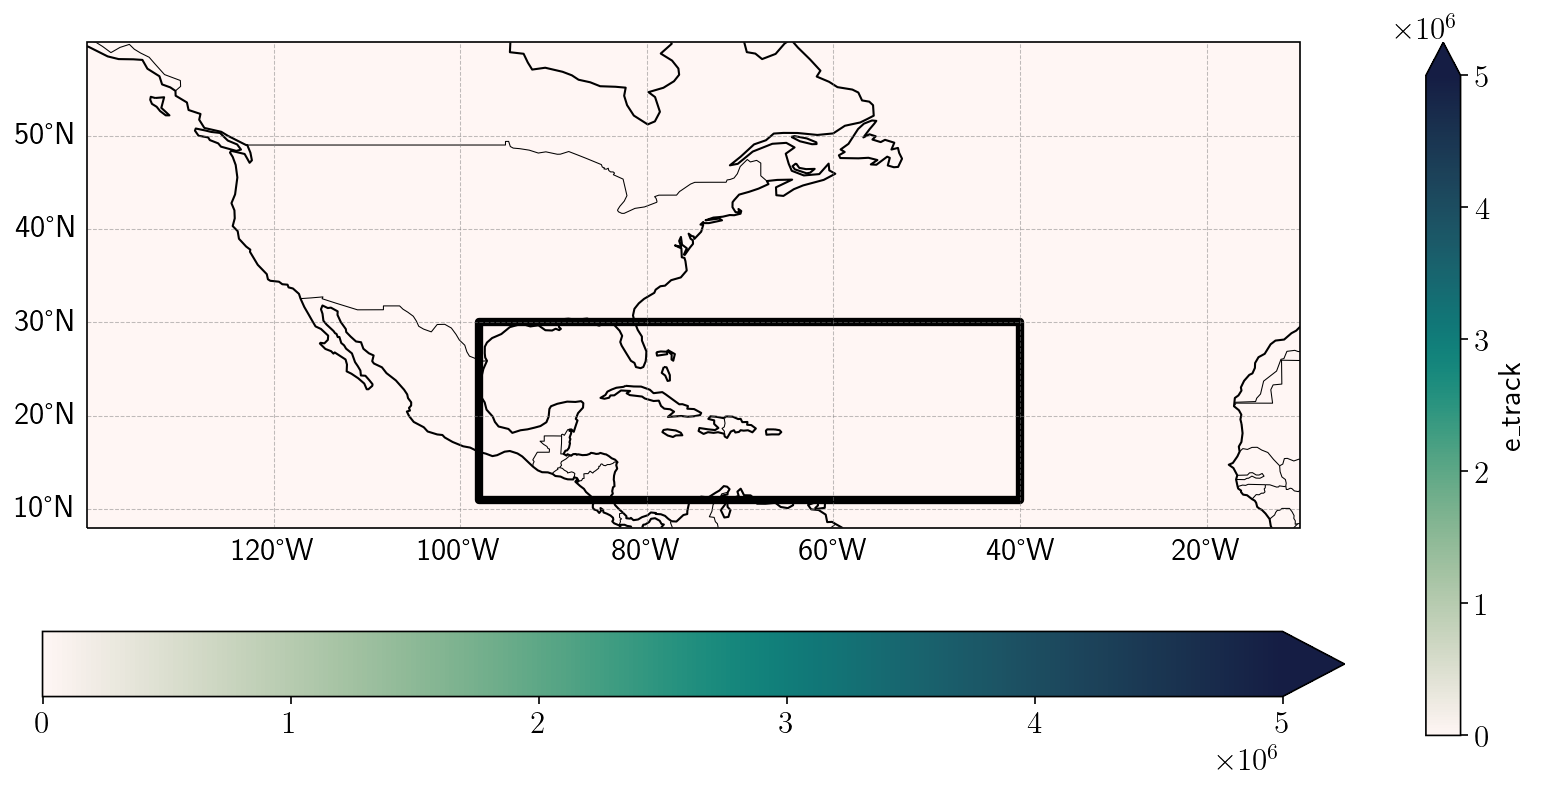

In [73]:
# Declare paths, etc.
region_name = "midwest" 
fig_path = ddir_X 
time_name = "005272013-0604013 Case Study"
output_file_path = ddir_X 

# Identify vars
variable_name = "total precipitated water"

# Create plot
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
vmin = 0
# vmax = 5e8 #e_track_sum_X.max()
vmax = 5e6

# Plot the data
#cf = e_track_sum_X.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.tempo, norm=colors.LogNorm(vmin=vmin, vmax=vmax))
cf = empty_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.tempo, vmin=vmin, vmax=vmax, extend = 'max')


# Specify the desired latitude and longitude limits
lon_min, lon_max = -140, -10 # Global LSM
lat_min, lat_max = 8, 60

# Set the extent of the map
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
gls = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='black')
# add these before plotting
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels

#Put Boxes Around Regions for Averaging
ring1 = LinearRing(list(zip(box_lons, box_lats)))
ax.add_geometries([ring1], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=4)

#fig.colorbar(cf,ax=ax, label='evaporated water', extend='max', orientation='horizontal')
fig.colorbar(cf,ax=ax, extend='max', orientation='horizontal')


# Set plot title
#plt.title('Case Study: 2011 Missouri River Floods \n May 01-June 30, 2011', fontsize=24)
#plt.title('Case Study: 2013 Midwest Flooding \n May 27-June 4, 2013', fontsize=24)
#plt.title('Moisture Source Region', fontsize=24)

#plt.title('South Region Precipitation MJJA 2008-2021', fontsize=24)


# Save the figure
#plt.savefig(ddir_X+"SOUTHUS_e_track_2013_casestudy.jpg")

# Show the plot
plt.show()

In [214]:
ddir_X

'/Users/marcodia/Research/Data/Moisture_Tracking/SouthUSMBA_Aug30/'